Dataset: https://github.com/Yurushia1998/SatelliteDataset

* Данный датасет состоит из 3 116 изображений и масок как синтезированных, так и реальных изображений спутников и космических станций (размер масок — 1 280x720).
* Каждый космический аппарат разделён максимум на три части, включая корпус, солнечную панель и антенну, помеченные, соответственно, тремя цветами — зелёным, красным и синим.
* В папке images находятся изображения, в папке mask — маски объектов.
* Изображение с индексом 0-1002 имеет точную маску, а изображения с индексом 1003-3116 — грубую маску.
* Наборы данных разделены на две части: обучающую выборку, включая 403 точные маски из индексов 0-402, и 2 114 грубых масок из индекса 1003-3116.
* Набор данных val включает 600 изображений с точной маской, проиндексированных от 403 до 1002.


In [7]:
%%capture out
!pip install torchmetrics pytorch_lightning -U
!pip install albucore==0.0.16

In [38]:
import os
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from pathlib import Path
import time
from IPython.display import FileLink
from collections import OrderedDict
import random
import pandas as pd
import segmentation_models_pytorch as smp
from torch.optim import lr_scheduler

import warnings
warnings.filterwarnings("ignore")

In [9]:
# Directory setting
IMAGES = '/kaggle/input/satellites/Final_dataset/images/'
MASKS = '/kaggle/input/satellites/Final_dataset/mask/'
OUT = '/kaggle/working/'

SEED = 33

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(f'Using {device} device')

Using cuda device


In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Set seed
seed_everything(SEED)


def load_img(path):
    img_bgr = cv2.imread(path)
    #print(img_bgr.shape)
    img_rgb = img_bgr[:, :, ::-1]
    return img_rgb


def load_mask(path):
    try:
        mask = cv2.imread(path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = np.where(mask>0, 1, 0)
    except:
        return None
    return mask


def group_bboxes(df):
    df_ = df.copy()
    df_['segment_count'] = 1
    df_ = df_.groupby(['id', 'width', 'height', 'cell_type']).count().reset_index()
    return_df = df_[['id', 'width', 'height', 'cell_type', 'segment_count']]
    return return_df


def create_gallery(array, ncols=4):
    """Display multiple images in a gallery style.
    """    
    h,w = array[0].shape[0], array[0].shape[1]
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows * ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
        .swapaxes(1,2)
        .reshape(height*nrows, width*ncols, intensity))
    
    for hor_pad in range(result.shape[0]//h):
        result[h*hor_pad,:,:] = 255
    for ver_pad in range(result.shape[1]//w):
        result[:,w*ver_pad,:] = 255

    return result


def IoU(preds, targs, eps: float = 1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]

    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1, device=device)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1) #Concatenates the given sequence of seq tensors in the given dimension.

    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]

        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()

        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)

    true_1_hot = true_1_hot.type(preds.type())

    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)  # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()  # find mean of class IoU values
    return iou


def display_few_examples_from_data(dataset, n=4):
    figure, ax = plt.subplots(nrows=n, ncols=2, figsize=(6, n*3))
    for i,m in enumerate(np.random.choice(len(dataset),n,replace=False)): #range(n)
        image, mask,_ = dataset.__getitem__(m)
        ax[i, 0].imshow(image.clone().cpu().numpy().transpose((1,2,0)).astype(np.uint8))
        ax[i, 1].imshow(mask.clone().cpu().numpy().astype(np.uint8), interpolation="nearest")

        ax[i, 0].set_title(f"{_}")
        ax[i, 1].set_title("Mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()


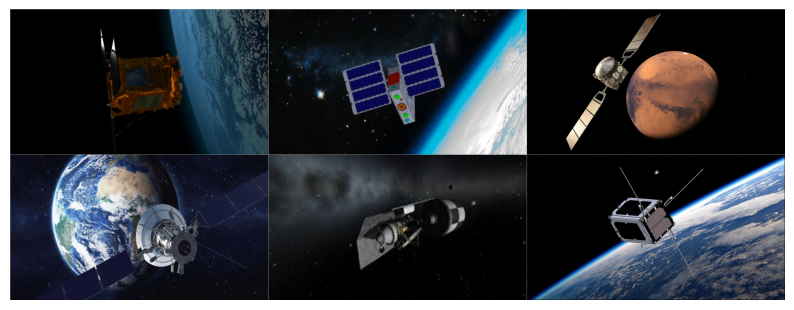

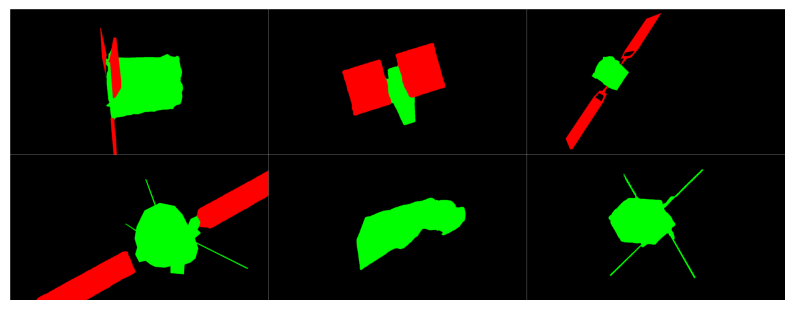

In [11]:
names = Path(IMAGES + 'train/').glob('*.png')
img_list, msk_list = [], []

for i, img_name in enumerate(names):
    img_list.append(load_img(img_name))
    mask_name = Path(str(img_name).replace(".", "_mask.").replace("images", "mask"))
    msk_list.append(load_img(mask_name.as_posix()))
    if i == 5: 
        break
        
for i in [img_list, msk_list]:
    plt.figure(figsize=(10,10))
    plt.imshow(create_gallery(np.array(i), ncols=3));
    plt.axis('off');

In [12]:
CHECK_EXT = True

if CHECK_EXT:
    img_shape = set()
    img_ext = set()

    for path in [IMAGES, MASKS]:
        print(path.split('/')[-2])
        for folder in ['train/', 'val/']:
            print(f"   {folder}:", len(os.listdir(path+folder)))
            names = Path(path + folder).glob('*')
            pbar = tqdm(names, total=len(os.listdir(path + folder)))
            for img_name in pbar:
                img = load_img(img_name.as_posix())
                img_shape.add(img.shape)
                img_ext.add(img_name.suffix)

    print(f'Image shapes: {img_shape}.')
    print(f'Image extensions: {img_ext}.')

images
   train/: 2119


  0%|          | 0/2119 [00:00<?, ?it/s]

   val/: 374


  0%|          | 0/374 [00:00<?, ?it/s]

mask
   train/: 2387


  0%|          | 0/2387 [00:00<?, ?it/s]

   val/: 390


  0%|          | 0/390 [00:00<?, ?it/s]

Image shapes: {(720, 1280, 3)}.
Image extensions: {'.png'}.


In [13]:
train_nomask = []
val_nomask = []
subsets = ['train/', 'val/']
nomask_dict = dict((i,[]) for i in subsets)

for i in subsets:
    for filename in os.listdir(IMAGES + i):
            mask_path = MASKS + i + filename.replace(".", "_mask.")
            if os.path.exists(mask_path)==False:
                nomask_dict[i].append(filename)

print(f"NO mask for {len(nomask_dict['train/'])} in TRAIN")
print(f"NO mask for {len(nomask_dict['val/'])} in VAL")

NO mask for 97 in TRAIN
NO mask for 130 in VAL


In [14]:
class SatelDataset(Dataset):
    def __init__(self, split="train/", transform=None):
        self.images_filenames = os.listdir(IMAGES + split) 
        self.mask_filenames = os.listdir(MASKS + split)       
        self.transform = transform
        self.split = split

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image_path = IMAGES + self.split + image_filename
        mask_path = MASKS + self.split + image_filename.replace(".", "_mask.")

        if os.path.exists(mask_path)==False:
            
            return self.__getitem__(idx + 1 if (idx + 1) < self.__len__() else 0)
        else:
            image, mask = load_img(image_path), load_mask(mask_path)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask, image_filename

In [15]:
train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])


val_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
        ToTensorV2()
    ])

train_dataset = SatelDataset("train/", transform=train_transform)
val_dataset = SatelDataset("val/", transform=val_transform)
print(len(train_dataset), len(val_dataset))

2119 374


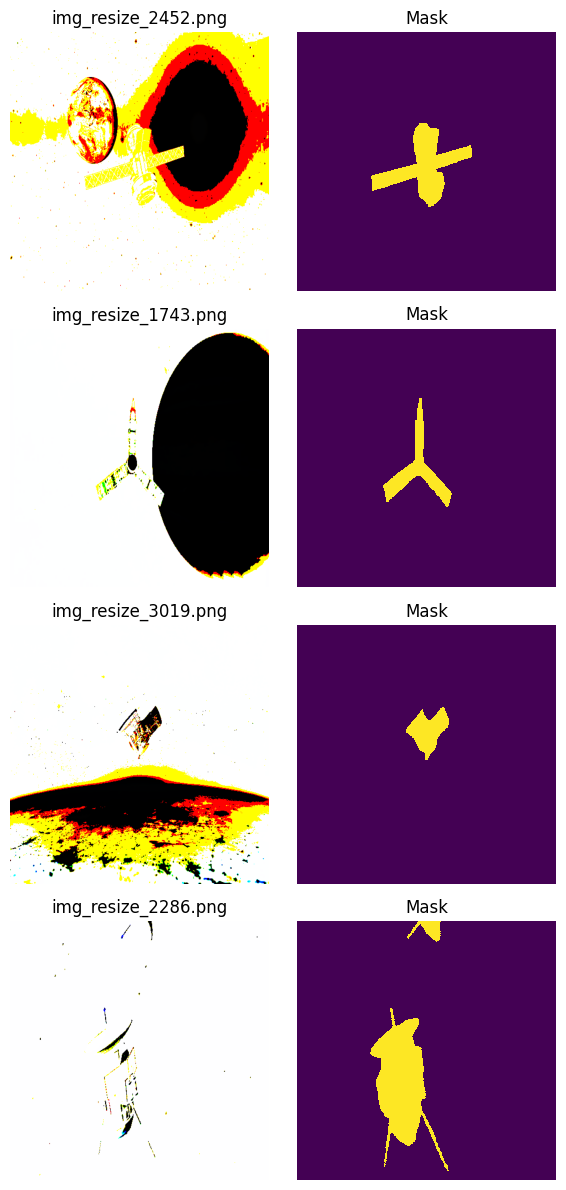

================Validation dataset================


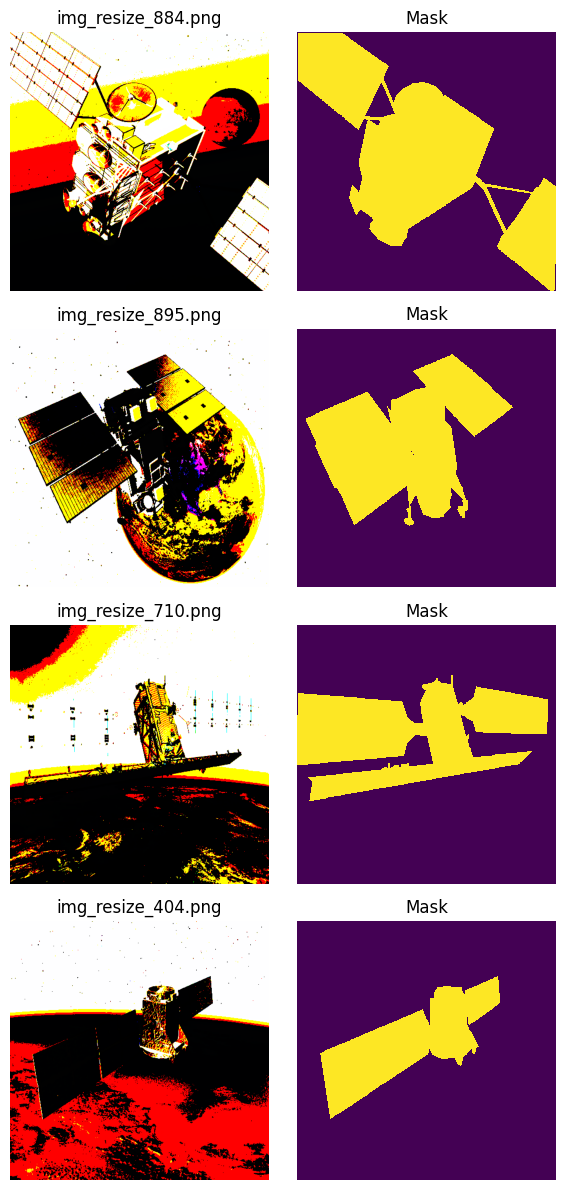

In [16]:
display_few_examples_from_data(train_dataset)
print("================Validation dataset================")
display_few_examples_from_data(val_dataset)

# Case #1. 
## UNet

In [17]:
class DoubleConv(nn.Module):
    """DoubleConv is a basic building block of the encoder and decoder components. 
    Consists of two convolutional layers followed by a ReLU activation function.
    """    
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.double_conv(x)
        return x


class Down(nn.Module):
    """Downscaling.
    Consists of two consecutive DoubleConv blocks followed by a max pooling operation.
    """    
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x


class Up(nn.Module):
    """Upscaling.
    Performed using transposed convolution and concatenation of feature maps from the corresponding "Down" operation.
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input tensor shape: (batch_size, channels, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x
    

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        
        self.down4 = Down(512,1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        #x = torch.sigmoid(x)
        return x

In [20]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 8
EPOCHS = 5
WEIGHT_DECAY = 0.0001
LR = 0.0001
MOMENTUM = 0.9
# Threshold for mask prediction
THRESHOLD = 0.5


class SegModel(pl.LightningModule):
    def __init__(self, train_dataset, val_dataset):
        super(SegModel, self).__init__()
        self.batch_size = BATCH_SIZE
        self.learning_rate = LR
        self.net = UNet()

        self.trainset = train_dataset
        self.valset = val_dataset
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        img, mask, _ = batch
        img = img.to(device).float()
        mask = mask.to(device).float()
        mask = mask.view(img.shape[0], -1, 512, 512)
        out = self.forward(img) # [B, 1, H, W]
        loss_val = self.criterion(out.squeeze(1), mask.squeeze(1)) # [B, 1, H, W] -> # [B, H, W]
        iou_score = IoU(out.float(), mask.long()) #torch.long and torch.int64 are synonymous
        self.log("train_loss", loss_val)
        self.log("train_iou", iou_score, prog_bar=True)
        return loss_val
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]

    def train_dataloader(self):
        return DataLoader(self.trainset, num_workers=NUM_WORKERS, 
                          batch_size=self.batch_size, shuffle=True, pin_memory=True)#, prefetch_factor=2,multiprocessing_context='fork',

    def val_dataloader(self):
        return DataLoader(self.valset, num_workers=NUM_WORKERS, multiprocessing_context='fork',
                          batch_size=self.batch_size, shuffle=False, pin_memory=True) 

    def validation_step(self, batch, batch_idx):
        img, mask, _ = batch
        img = img.to(device).float()
        mask = mask.to(device).float()
        mask = mask.view(img.shape[0], -1, 512, 512)
        out = self.forward(img)
        loss_val = self.criterion(out.squeeze(1), mask.squeeze(1))
        iou_score = IoU(out.float(), mask.long())
        self.log("val_loss", loss_val, prog_bar=True)
        self.log("val_iou", iou_score, prog_bar=True, on_epoch=True)

In [21]:
TRAIN = True

if TRAIN: 
    start_time = time.time()

    model = SegModel(train_dataset, val_dataset)
    model.to(device)

    trainer = pl.Trainer(
        max_epochs=5,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_iou"),
            LearningRateMonitor("epoch"),
            EarlyStopping(monitor="val_iou", mode="max", patience=15),
        ],  # Log learning rate every epoch
        log_every_n_steps=1
    )


    trainer.fit(model)
    
    valid_metrics_unet = trainer.validate(model, dataloaders=model.val_dataloader())
    
    time_unet = round((time.time() - start_time)/60, 2)
    print(f"Training time {round(time_unet,2)}")

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.7400044202804565     │
│         val_loss          │    0.13855689764022827    │
└───────────────────────────┴───────────────────────────┘

Training time 26.71


In [22]:
# saving model weights
torch.save(model.state_dict(), '/kaggle/working/unet.pth')
#!zip -r /kaggle/working/unet_5.zip /kaggle/working/unet.pth
#os.chdir(OUT)
#FileLink(r'unet_5.zip')

!ls /kaggle/working/

lightning_logs	unet.pth


### MODEL INFERENCE

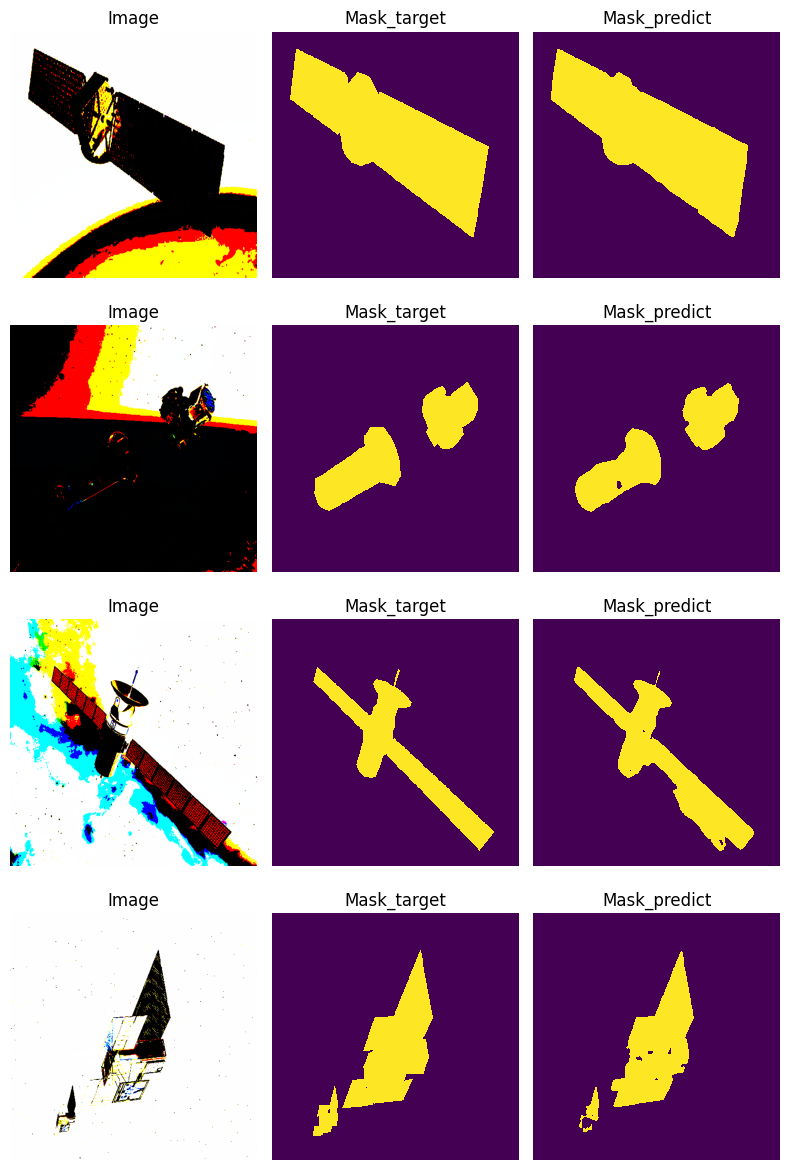

In [23]:
RUN_INFERENCE = True

if RUN_INFERENCE:
    # Data Loader
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        num_workers=NUM_WORKERS, 
        shuffle=False, 
        multiprocessing_context='fork'
    )
    
    # Load model, loss function, and optimizing algorithm
    model_unet = UNet().to(device)
    state_dict = OrderedDict((k.replace('net.', ''),v) for k,v in torch.load(OUT+'unet.pth').items())
    model_unet.load_state_dict(state_dict)
       
    # Start Inference
    model_unet.eval()
    with torch.no_grad():
        for imgs, masks, names in val_loader:
            #print(imgs.shape, masks.shape, len(names))
            imgs = imgs.to(device).float()
            output = model_unet(imgs)
            output = output.detach().cpu().numpy()
            break

            
    f,ax = plt.subplots(4,3,figsize=(8,12))
    for i in range(4):
        ax[i,0].imshow(imgs[i].clone().cpu().numpy().transpose((1,2,0)).astype(np.uint8))
        ax[i,1].imshow(masks[i].clone().cpu().numpy().astype(np.uint8), interpolation="nearest")
        ax[i,2].imshow(torch.tensor(output[i]>THRESHOLD).squeeze(0).cpu().numpy().astype(np.uint8), interpolation="nearest")
        ax[i,0].set_title(f"Image")
        ax[i,1].set_title(f"Mask_target")
        ax[i,2].set_title(f"Mask_predict")
        ax[i,0].set_axis_off()
        ax[i,1].set_axis_off()
        ax[i,2].set_axis_off()
                
    plt.tight_layout()
    plt.show()

===============================================================================
# Case #2. 
## UNet w. EfficientNet-backbone pretrained on Imagenet-dataset

Segmentation Models. Python library with Neural Networks for Image Segmentation based on PyTorch.

In [24]:
%%capture
!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
#!pip install lightning albumentations

In [25]:
# Some training hyperparameters
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 4
EPOCHS = 5
LR = 0.0001
# Threshold for mask prediction
T_MAX = EPOCHS * len(train_dataset)/BATCH_SIZE

In [26]:
CHECK_INTERSECT = False

if CHECK_INTERSECT:
    train_names = [x[2] for x in train_dataset]
    val_names = [x[2] for x in val_dataset]
    print(train_names[:5])
    # check for subsets intersection
    #assert set(train_dataset).isdisjoint(set(val_dataset)) #Return True if no items in set x is present in set y
    print(f'NO intersection in subsets: {set(train_dataset).isdisjoint(set(val_dataset))}')

In [27]:
print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(val_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=NUM_WORKERS)
valid_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=NUM_WORKERS)

Train size: 2119
Valid size: 374


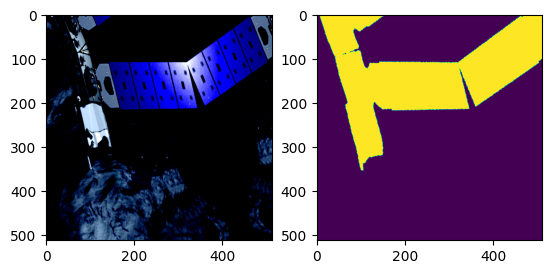

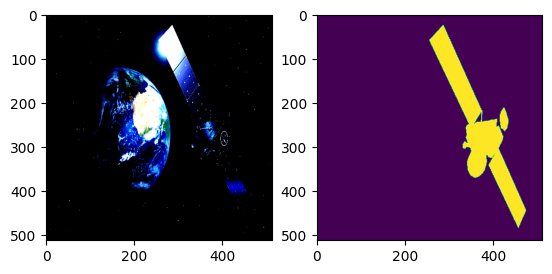

In [32]:
# some random samples
for subset in [train_dataset, val_dataset]:
    random_id = int(np.random.choice(len(subset),1,replace=False))
    sample = subset[random_id]
    plt.subplot(1, 2, 1)
    # for visualization we have to transpose back to HWC
    plt.imshow(sample[0].numpy().transpose(1, 2, 0))
    plt.subplot(1, 2, 2)
    # for visualization we have to remove 3rd dimension of mask
    plt.imshow(sample[1].squeeze())
    plt.show()


In [36]:
class SatModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            encoder_weights='imagenet',
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        #image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask, _ = batch
        image = image.to(device).float()
        mask = mask.to(device).float()
        mask = mask.view(image.shape[0], -1, 512, 512)
        
        #image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        #mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LR)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [40]:
TRAIN = True

if TRAIN:
    start_time = time.time()
    model = SatModel("unet", "efficientnet-b0", in_channels=3, out_classes=1)
    #model = SatModel("unet", "resnet34", in_channels=3, out_classes=1)
    #model = SatModel("FPN", "resnet34", in_channels=3, out_classes=1)
    #model = SatModel("deeplabv3plus", "mobilenet_v2", in_channels=3, out_classes=1)

    trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=valid_dataloader,
    )

    # run validation dataset
    valid_metrics_unet_eff = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
    print(valid_metrics_unet_eff)

    time_unet_eff = round((time.time() - start_time)/60,2)
    print(f"Training time {time_unet_eff}")

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.9285642504692078, 'valid_dataset_iou': 0.9372154474258423}]
Training time 7.1


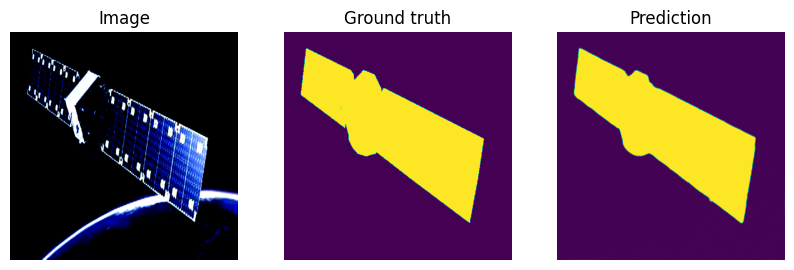

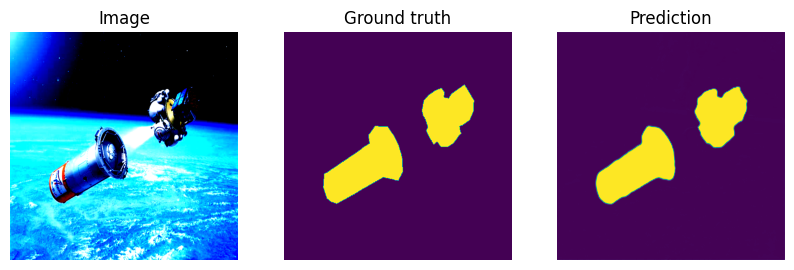

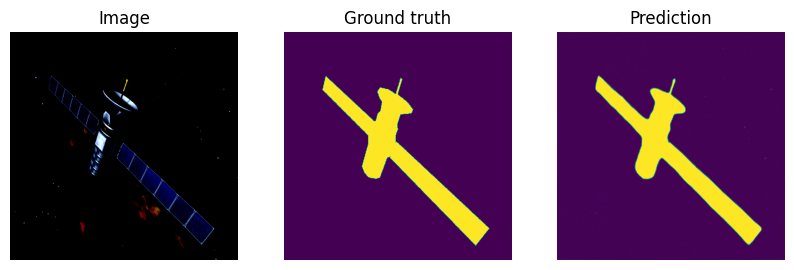

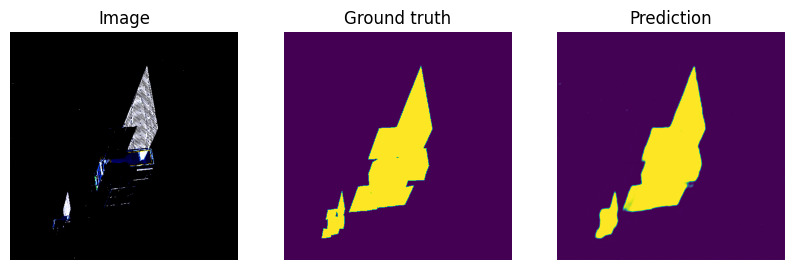

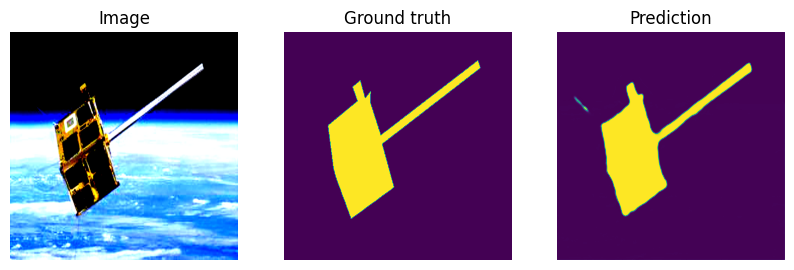

In [41]:
batch = next(iter(valid_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(zip(batch[0], batch[1], pr_masks)):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

# Summary

In [42]:
summary = pd.DataFrame(
    [
    ['UNet', time_unet, valid_metrics_unet[0]['val_iou']], 
    ['UNet-efficNet', time_unet_eff, valid_metrics_unet_eff[0]['valid_dataset_iou']]
    ], 
    columns=['Model', 'train_time, min', 'IoU'],
    ).set_index(['Model'])

summary.style.set_properties(subset=summary.columns, **{'width': '130px', 'text-align': 'right'})

,"train_time, min",IoU
Model,,
UNet,26.710000,0.740004
UNet-efficNet,7.100000,0.937215
